In [1]:
# Introducing YOLO v2

In [2]:
## Classifying and localizing images and detecting objects

In [3]:
## Proposing and detecting objects using CNNs

In [4]:
## Using YOLO v2

In [5]:
### Using a pre-trained YOLO model for object detection

In [19]:
import os
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import scipy.io
import scipy.misc
import numpy as np
from PIL import Image
from tensorflow.keras import backend as K
from keras.models import load_model
from yad2k.models.keras_yolo import yolo_head, yolo_eval
import colorsys
import random
from PIL import Image, ImageDraw, ImageFont
import cv2
from ultralytics import YOLO

In [14]:
def read_classes(classes_path):
    with open(classes_path) as f:  # Mở tệp chứa danh sách các lớp
        class_names = f.readlines()  # Đọc từng dòng trong tệp
        class_names = [c.strip() for c in class_names]  # Loại bỏ ký tự thừa 
        return class_names  # Trả về danh sách tên các lớp


In [8]:
def read_anchors(anchors_path):
    with open(anchors_path) as f:  # Mở tệp chứa các giá trị anchors
        anchors = f.readline()  # Đọc toàn bộ dòng chứa anchors
        anchors = [float(x) for x in anchors.split(',')]  # Chuyển đổi các giá trị
        anchors = np.array(anchors).reshape(-1, 2)  # Chuyển đổi thành mảng NumPy
        return anchors  # Trả về mảng anchors


In [16]:
def generate_colors(class_names):
    # Tạo danh sách các giá trị HSV, mỗi giá trị tương ứng với một lớp
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    
    # Chuyển đổi HSV sang RGB và chuẩn hóa giá trị từ 0-1 thành 0-255
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), 
                                 int(x[2] * 255)), colors))
    
    # Sử dụng seed cố định để màu sắc luôn giống nhau ở các lần chạy
    random.seed(10101)  
    random.shuffle(colors)  # Trộn màu để làm giảm tính liên tiếp giữa các lớp
    random.seed(None)  # Đặt lại seed về mặc định để không ảnh hưởng các phần khác
    
    return colors  # Trả về danh sách màu sắc


In [10]:
def scale_boxes(boxes, image_shape):
    """
    Điều chỉnh các bounding boxes để phù hợp với kích thước của ảnh.
    """
    height = image_shape[0]  # Chiều cao của ảnh
    width = image_shape[1]   # Chiều rộng của ảnh
    
    # Tạo tensor chứa các giá trị chiều cao và chiều rộng lặp lại
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])  # Định dạng lại thành tensor [1, 4]
    
    # Scale các box từ [0,1] sang toạ độ ảnh thực tế
    boxes = boxes * image_dims
    return boxes  # Trả về các box đã điều chỉnh


In [11]:
def preprocess_image(img_path, model_image_size):
    """
    Tiền xử lý ảnh trước khi đưa vào mô hình.
    """
    # Kiểm tra loại ảnh
    image_type = imghdr.what(img_path)  # Xác định định dạng ảnh
    image = Image.open(img_path)  # Mở ảnh từ đường dẫn
    
    # Resize ảnh về kích thước yêu cầu của mô hình
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    
    # Chuyển ảnh thành numpy array và chuẩn hóa giá trị pixel
    image_data = np.array(resized_image, dtype='float32')  # Chuyển ảnh thành mảng numpy
    image_data /= 255.  # Chuẩn hóa giá trị pixel về [0, 1]
    
    # Thêm chiều batch vào mảng (batch_size = 1)
    image_data = np.expand_dims(image_data, 0)
    
    return image, image_data  # Trả về ảnh gốc và ảnh đã xử lý


In [12]:
def draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors):
    """
    Vẽ khung bao quanh các đối tượng được phát hiện lên ảnh.
    """
    # Thiết lập font chữ cho nhãn
    font = ImageFont.truetype(font='font/FiraMonoMedium.otf',
                              size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    
    # Đặt độ dày của khung dựa trên kích thước ảnh
    thickness = (image.size[0] + image.size[1]) // 300
    
    # Duyệt qua từng đối tượng được phát hiện
    for i, c in reversed(list(enumerate(out_classes))):  
        predicted_class = class_names[c]  # Lấy tên lớp dự đoán
        box = out_boxes[i]  # Tọa độ bounding box
        score = out_scores[i]  # Xác suất dự đoán
        label = '{} {:.2f}'.format(predicted_class, score)  # Tạo nhãn dự đoán
        
        # Tính toán tọa độ góc trên và dưới của bounding box
        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        
        print(label, (left, top), (right, bottom))  # In thông tin nhãn và tọa độ
        
        # Xác định vị trí nhãn trên hoặc dưới bounding box
        label_size = draw.textsize(label, font)  # Kích thước nhãn
        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])  # Nhãn ở phía trên
        else:
            text_origin = np.array([left, top + 1])  # Nhãn ở phía dưới
        
        # Vẽ bounding box và nhãn
        draw = ImageDraw.Draw(image)
        for i in range(thickness):  
            draw.rectangle([left + i, top + i, right - i, bottom - i],
                           outline=colors[c])  # Vẽ viền bounding box
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)],
                       fill=colors[c])  # Vẽ nền cho nhãn
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)  # Vẽ nhãn
        
        del draw  # Giải phóng tài nguyên vẽ



image 1/1 D:\PTIT\IV\IV.1_XLA\BIG_ASSIGNMENT\Code\Chapter11\images\giraffe_zebra.jpg: 448x640 2 zebras, 3 giraffes, 73.8ms
Speed: 0.9ms preprocess, 73.8ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


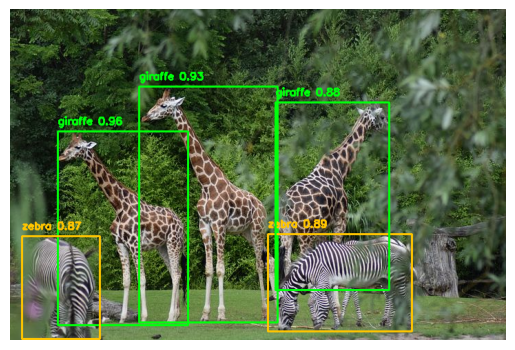


image 1/1 D:\PTIT\IV\IV.1_XLA\BIG_ASSIGNMENT\Code\Chapter11\images\cars.jpg: 480x640 2 persons, 11 cars, 78.6ms
Speed: 15.6ms preprocess, 78.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


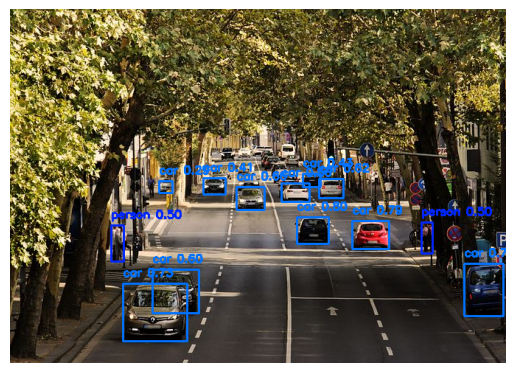


image 1/1 D:\PTIT\IV\IV.1_XLA\BIG_ASSIGNMENT\Code\Chapter11\images\tlqs1.jpg: 384x640 6 airplanes, 66.2ms
Speed: 2.0ms preprocess, 66.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


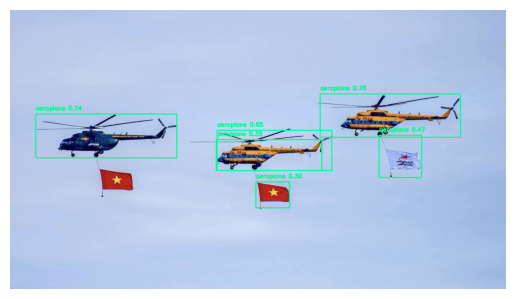


image 1/1 D:\PTIT\IV\IV.1_XLA\BIG_ASSIGNMENT\Code\Chapter11\images\tlqs2.jpg: 384x640 4 airplanes, 64.9ms
Speed: 2.0ms preprocess, 64.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


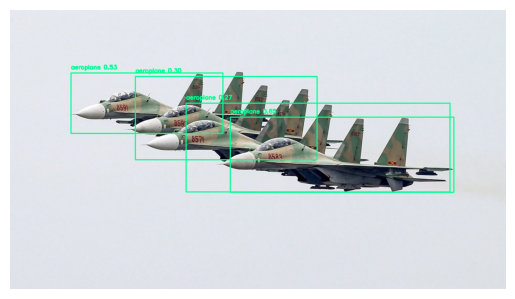


image 1/1 D:\PTIT\IV\IV.1_XLA\BIG_ASSIGNMENT\Code\Chapter11\images\tlqs3.jpg: 384x640 2 airplanes, 70.8ms
Speed: 2.7ms preprocess, 70.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


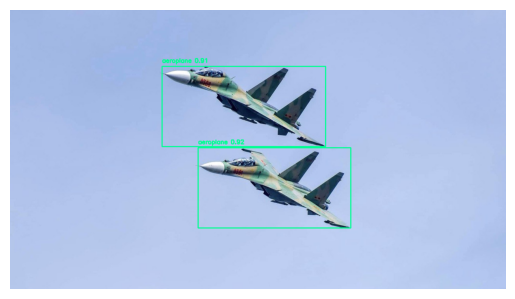


image 1/1 D:\PTIT\IV\IV.1_XLA\BIG_ASSIGNMENT\Code\Chapter11\images\tlqs4.jpg: 384x640 1 airplane, 68.8ms
Speed: 2.0ms preprocess, 68.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


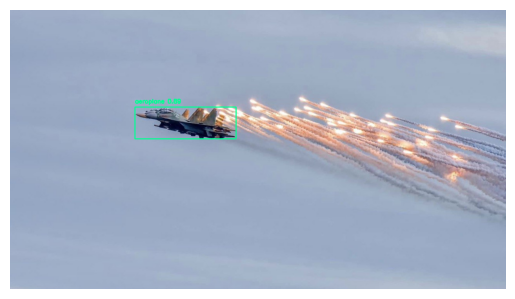


image 1/1 D:\PTIT\IV\IV.1_XLA\BIG_ASSIGNMENT\Code\Chapter11\images\tlqs5.jpg: 448x640 3 airplanes, 62.6ms
Speed: 2.1ms preprocess, 62.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


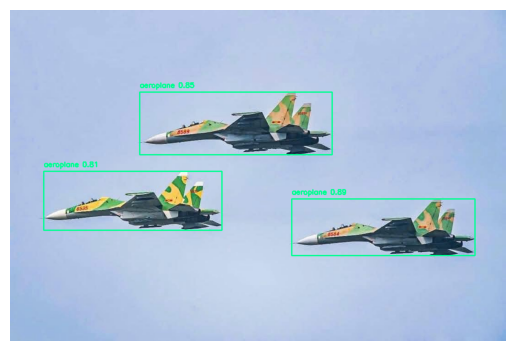


image 1/1 D:\PTIT\IV\IV.1_XLA\BIG_ASSIGNMENT\Code\Chapter11\images\tlqs6.jpg: 384x640 5 airplanes, 60.6ms
Speed: 1.9ms preprocess, 60.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


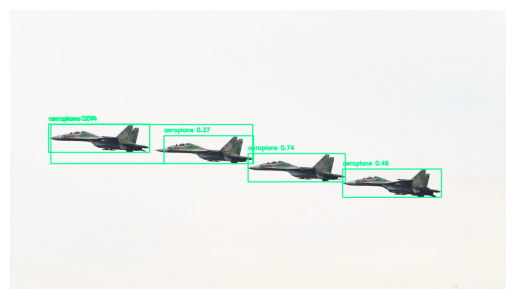

In [22]:
import cv2
import matplotlib.pyplot as plt
import random
import colorsys

# Tải mô hình YOLO v8 với trọng số từ tệp
yolo_model = YOLO('yolov8n.pt')

# Danh sách các tệp ảnh cần xử lý
image_files = ["giraffe_zebra.jpg", "cars.jpg", "tlqs1.jpg", 
               "tlqs2.jpg", "tlqs3.jpg", "tlqs4.jpg", "tlqs5.jpg", "tlqs6.jpg"]

# Đọc tên các lớp từ tệp và tạo danh sách màu sắc tương ứng
class_names = read_classes("yolo/coco_classes.txt")  # Đọc tên lớp từ tệp
colors = generate_colors(class_names)  # Tạo danh sách màu sắc ngẫu nhiên cho từng lớp

# Vòng lặp xử lý từng tệp ảnh
for input_image_name in image_files:
    image_path = f"images/{input_image_name}"  # Tạo đường dẫn đầy đủ cho ảnh

    # Thực hiện suy luận (detection) trên ảnh
    results = yolo_model(image_path)  # Kết quả là các bounding box và thông tin lớp

    # Lấy thông tin phát hiện từ kết quả (boxes, confidence, classes)
    # Tensor chứa thông tin [x1, y1, x2, y2, confidence, class]
    detections = results[0].boxes.data  

    # Đọc ảnh sử dụng OpenCV
    image = cv2.imread(image_path)

    # Vẽ các khung dự đoán và nhãn lên ảnh
    for det in detections:
        x1, y1, x2, y2, confidence, cls = det  # Lấy tọa độ và thông tin dự đoán
        # Tạo nhãn hiển thị gồm tên lớp và độ chính xác
        label = f"{class_names[int(cls)]} {confidence:.2f}"  

        # Lấy màu sắc tương ứng với lớp từ danh sách màu đã tạo
        color = colors[int(cls)]

        # Vẽ hình chữ nhật (bounding box) lên ảnh
        image = cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
        # Thêm nhãn (label) phía trên bounding box
        image = cv2.putText(image, label, (int(x1), int(y1) - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Lưu ảnh đã xử lý vào thư mục đầu ra
    output_path = f"output/{input_image_name}"  # Tạo đường dẫn lưu kết quả
    cv2.imwrite(output_path, image)  # Ghi ảnh ra tệp

    # Hiển thị ảnh đã xử lý bằng matplotlib
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Chuyển đổi ảnh từ BGR sang RGB 
    plt.axis('off')  # Tắt trục hiển thị
    plt.show()  # Hiển thị ảnh


In [16]:
# Deep semantic segmentation with DeepLab V3+

In [21]:
## Semantic segmentation

In [22]:
## DeepLab V3+

In [23]:
### DeepLab v3 architecture

In [25]:
### Steps you must follow to use DeepLab V3+ model for semantic segmentation

The following Variables were used a Lambda layer's call (tf.nn.convolution_2052), but
are not present in its tracked objects:
  <tf.Variable 'Conv/kernel:0' shape=(3, 3, 3, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.depthwise_conv2d_918), but
are not present in its tracked objects:
  <tf.Variable 'expanded_conv_depthwise/kernel:0' shape=(3, 3, 32, 1) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2053), but
are not present in its tracked objects:
  <tf.Variable 'expanded_conv_project/kernel:0' shape=(1, 1, 32

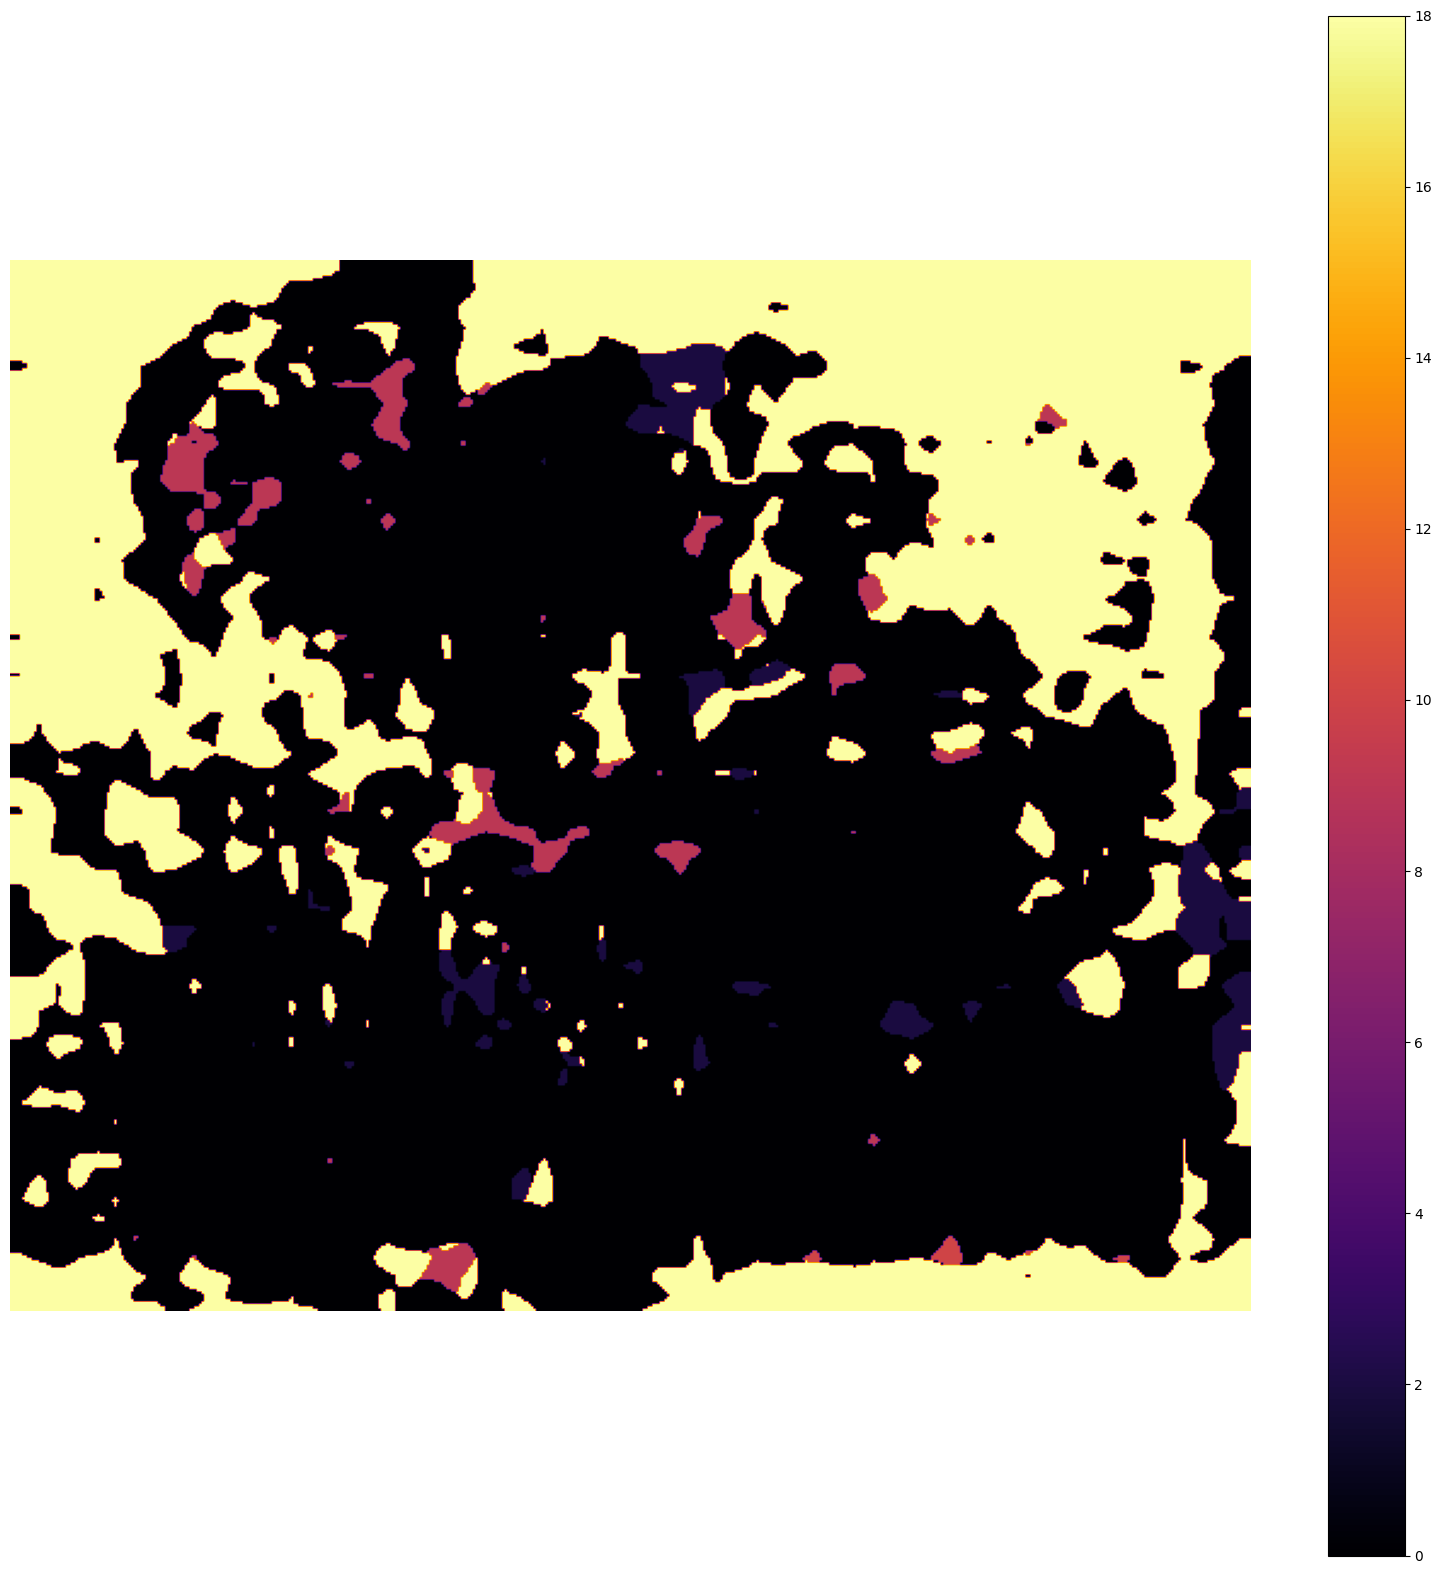

In [77]:
import os
os.chdir('keras-deeplab-v3-plus-master')  # Chuyển sang thư mục chứa mô hình Deeplabv3+

from matplotlib import pyplot as pylab
import cv2  # Dùng để thay đổi kích thước ảnh
import numpy as np
import tensorflow as tf
from model import Deeplabv3  # Import mô hình Deeplabv3+

# Khởi tạo mô hình Deeplabv3+
deeplab_model = Deeplabv3()

# Đường dẫn ảnh đầu vào và đầu ra
pathIn = 'input'  # Thư mục chứa ảnh đầu vào
pathOut = 'output'  # Thư mục chứa ảnh đầu ra đã phân đoạn

# Đọc ảnh đầu vào
img = pylab.imread(pathIn + "/cycle.jpg")

# Tính toán tỷ lệ để thay đổi kích thước ảnh (512 là kích thước đầu vào của mô hình)
w, h, _ = img.shape
ratio = 512. / np.max([w, h])

# Thay đổi kích thước ảnh theo tỷ lệ đã tính
resized = cv2.resize(img, (int(ratio * h), int(ratio * w)))
resized = resized / 127.5 - 1.  # Chuẩn hóa giá trị pixel ảnh về khoảng [-1, 1]

# Thêm padding (nếu cần) để đảm bảo ảnh có kích thước phù hợp với mô hình
pad_x = int(512 - resized.shape[0])
resized2 = np.pad(resized, ((0, pad_x), (0, 0), (0, 0)), mode='constant')

# Chuyển ảnh thành tensor và mở rộng để thêm chiều batch
input_data = tf.convert_to_tensor(np.expand_dims(resized2, 0), dtype=tf.float32)

# Chạy suy luận với mô hình
res = deeplab_model.call(input_data)

# Lấy nhãn phân đoạn (label) từ kết quả đầu ra
labels = np.argmax(tf.squeeze(res).numpy(), axis=-1)

# Hiển thị ảnh phân đoạn
pylab.figure(figsize=(20, 20))
pylab.imshow(labels[:-pad_x], cmap='inferno')  # Loại bỏ padding trước khi hiển thị
pylab.axis('off')  # Tắt hiển thị trục
pylab.colorbar()  # Thêm thanh màu (legend) để hiển thị các nhãn
pylab.show()

# Lưu ảnh phân đoạn vào thư mục đầu ra
pylab.savefig(pathOut + "\\segmented.jpg", bbox_inches='tight', pad_inches=0)
pylab.close()

# Quay lại thư mục gốc
os.chdir('..')


In [2]:
# Transfer learning – what it is, and when to use it

In [3]:
## Transfer learning with Keras

In [78]:
from keras.applications import VGG16  # Import mô hình VGG16 từ thư viện Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras import models, layers, optimizers 
from tensorflow.keras.layers import BatchNormalization 
import matplotlib.pylab as plt  
from keras.preprocessing.image import load_img 

# Tải mô hình VGG16, loại bỏ lớp phân loại cuối cùng (include_top=False)
# Input ảnh có kích thước 224x224 và 3 kênh màu (RGB)
# 'imagenet' là tập dữ liệu được dùng để huấn luyện mô hình VGG16 này
vgg_conv = VGG16(weights='imagenet',
                  include_top=False,  # Không bao gồm lớp phân loại cuối cùng
                  input_shape=(224, 224, 3))  # Kích thước ảnh đầu

In [80]:
import numpy as np  # Import thư viện numpy để xử lý mảng

# Đường dẫn đến thư mục huấn luyện và xác thực
train_dir = './flower_photos/train'  # Đường dẫn tới ảnh huấn luyện
validation_dir = './flower_photos/valid'  # Đường dẫn tới ảnh xác thực

# Số lượng ảnh trong mỗi lớp (3 lớp hoa, mỗi lớp có 50 ảnh huấn luyện và 5 ảnh xác thực)
nTrain = 50 * 3  # Tổng số ảnh huấn luyện
nVal = 5 * 3  # Tổng số ảnh xác thực

# Khởi tạo ImageDataGenerator để chuẩn hóa dữ liệu
datagen = ImageDataGenerator(rescale=1./255)  # Chuyển đổi giá trị pixel về khoảng [0,1]

batch_size = 25  # Kích thước batch mỗi lần huấn luyện

# Tạo các mảng để lưu các đặc trưng (features) và nhãn (labels) cho ảnh huấn luyện
train_features = np.zeros(shape=(nTrain, 7, 7, 512)) 
train_labels = np.zeros(shape=(nTrain, 3)) 

# Tạo một generator cho việc đọc và xử lý dữ liệu huấn luyện từ thư mục
train_generator = datagen.flow_from_directory(
    train_dir,  # Đường dẫn tới thư mục ảnh huấn luyện
    target_size=(224, 224),  # Kích thước ảnh đưa vào mô hình là 224x224
    batch_size=batch_size,  # Kích thước mỗi batch là 25
    class_mode='categorical',  # Nhãn ở dạng one-hot encoding (vì có nhiều lớp)
    shuffle=True  # Xáo trộn dữ liệu mỗi lần đọc batch
)


Found 150 images belonging to 3 classes.


In [81]:
i = 0  # Khởi tạo biến chỉ số để theo dõi tiến trình trong quá trình lặp qua các batch

# Duyệt qua các batch từ train_generator
for inputs_batch, labels_batch in train_generator:
    # Trích xuất đặc trưng của batch ảnh bằng cách sử dụng mô hình VGG16
    features_batch = vgg_conv.predict(inputs_batch)  # Sử dụng VGG16

    # Lưu trữ đặc trưng của ảnh vào mảng train_features 
    train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    
    # Lưu trữ nhãn của ảnh vào mảng train_labels 
    train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch

    i += 1  # Tăng chỉ số batch lên 1 sau mỗi lần lặp
    
    # Nếu đã xử lý đủ tất cả ảnh huấn luyện, thoát khỏi vòng lặp
    if i * batch_size >= nTrain:
        break

# Sau khi duyệt qua tất cả các batch, reshape mảng train_features thành một mảng 2D
# Để mỗi đặc trưng của ảnh sẽ là một vector dài (7 * 7 * 512)
train_features = np.reshape(train_features, (nTrain, 7 * 7 * 512))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [82]:
# Tạo mảng để lưu trữ đặc trưng và nhãn cho tập xác thực
validation_features = np.zeros(shape=(nVal, 7, 7, 512))  # Mảng đặc trưng
validation_labels = np.zeros(shape=(nVal, 3))  # Mảng nhãn cho tập xác thực

# Tạo validation generator từ thư mục validation
validation_generator = datagen.flow_from_directory(
    validation_dir,  # Đường dẫn tới thư mục chứa dữ liệu xác thực
    target_size=(224, 224),  # Resize ảnh về kích thước 224x224
    batch_size=batch_size,  # Kích thước của batch
    class_mode='categorical',  # Dạng nhãn (one-hot encoding)
    shuffle=False)  # Không xáo trộn dữ liệu trong tập xác thực

i = 0  # Biến để theo dõi chỉ số batch
# Duyệt qua các batch ảnh trong tập xác thực
for inputs_batch, labels_batch in validation_generator:
    # Trích xuất đặc trưng của batch ảnh bằng mô hình VGG16
    features_batch = vgg_conv.predict(inputs_batch)

    # Lưu trữ đặc trưng vào mảng validation_features
    validation_features[i * batch_size : (i + 1) * batch_size] = features_batch
    
    # Lưu trữ nhãn vào mảng validation_labels
    validation_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    
    i += 1  # Tăng chỉ số batch lên 1

    # Nếu đã xử lý đủ số ảnh trong tập xác thực, thoát khỏi vòng lặp
    if i * batch_size >= nVal:
        break

# Reshape lại mảng validation_features để có thể sử dụng cho mô hình học sâu tiếp theo
validation_features = np.reshape(validation_features, (nVal, 7 * 7 * 512)) 


Found 15 images belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [83]:
# Khởi tạo mô hình mạng neural (fully-connected) với các lớp Dense
model = models.Sequential()

# Thêm lớp Dense đầu tiên, kích thước đầu vào là 7 * 7 * 512 
# Lớp này sẽ có 512 neuron với hàm kích hoạt ReLU
model.add(layers.Dense(512, activation='relu', input_dim=7 * 7 * 512))

# Thêm lớp BatchNormalization giúp chuẩn hóa các giá trị đầu ra từ lớp Dense
model.add(BatchNormalization())

# Thêm lớp Dropout với tỷ lệ 50% để tránh overfitting trong quá trình huấn luyện
model.add(layers.Dropout(0.5))

# Thêm lớp Dense thứ hai với 3 neuron đầu ra (do có 3 lớp trong bài toán phân loại hoa)
# Sử dụng hàm kích hoạt softmax để tính xác suất cho từng lớp
model.add(layers.Dense(3, activation='softmax'))

# Biên dịch mô hình với các tham số:
# - Optimizer Adam với learning rate = 1e-4
# - Hàm mất mát categorical_crossentropy (do đây là bài toán phân loại nhiều lớp)
# - Đánh giá hiệu suất mô hình qua độ chính xác (accuracy)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

# Huấn luyện mô hình với dữ liệu huấn luyện (train_features và train_labels)
# Đánh giá hiệu suất với dữ liệu xác thực (validation_features và validation_labels)
# Sử dụng batch_size đã được định nghĩa và huấn luyện trong 10 epochs
history = model.fit(train_features,
                    train_labels,
                    epochs=10,
                    batch_size=batch_size,
                    validation_data=(validation_features, validation_labels))


Epoch 1/10


C:\Users\MinhDuc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - acc: 0.3806 - loss: 1.5158 - val_acc: 0.6000 - val_loss: 0.7777
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - acc: 0.8786 - loss: 0.3206 - val_acc: 0.7333 - val_loss: 0.6463
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - acc: 0.9783 - loss: 0.0835 - val_acc: 0.8000 - val_loss: 0.5654
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - acc: 0.9981 - loss: 0.0286 - val_acc: 0.8000 - val_loss: 0.5155
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - acc: 1.0000 - loss: 0.0299 - val_acc: 0.8000 - val_loss: 0.5005
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - acc: 1.0000 - loss: 0.0209 - val_acc: 0.8000 - val_loss: 0.4993
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - acc: 1.0000 - loss: 0.0089 - val_acc: 0.8000 - val_loss: 0.4969
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - acc: 1.0000 - loss: 0.0205 - val_acc: 0.8000 - val_loss: 0.5021
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - acc: 1.0000 - loss: 0.0057 - val_acc: 0

In [88]:
fnames = validation_generator.filenames  # Danh sách tên các file ảnh
ground_truth = validation_generator.classes  # Nhãn thực tế của các ảnh 
label2index = validation_generator.class_indices  # Từ điển ánh xạ 

# Tạo từ điển ngược lại, từ chỉ số lớp đến tên lớp
idx2label = {v: k for k, v in label2index.items()}

# Dự đoán xác suất lớp cho từng ảnh trong bộ xác thực
predictions = model.predict(validation_features)  # Kết quả là (số ảnh, số lớp)
prob = model.predict(validation_features)
# Chuyển đổi xác suất thành nhãn lớp bằng cách chọn chỉ số lớp có xác suất cao nhất
predicted_labels = np.argmax(predictions, axis=1)  # Kết quả là nhãn dự đoán cho mỗi ảnh

# Tính toán chỉ số các ảnh mà mô hình dự đoán sai (lỗi)
errors = np.where(predicted_labels != ground_truth)[0]  # Lấy chỉ số ảnh bị dự đoán sai

# Lấy tổng số ảnh trong bộ xác thực
nVal = len(ground_truth)

# In ra số lượng lỗi (dự đoán sai) so với tổng số ảnh trong bộ xác thực
print("No of errors = {}/{}".format(len(errors), nVal))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
No of errors = 3/15


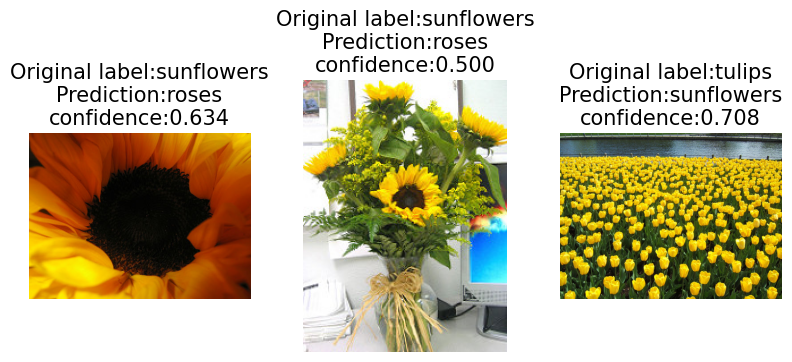

In [90]:
# Thiết lập kích thước cho biểu đồ
plt.figure(figsize=(20,12))

# Duyệt qua tất cả các ảnh bị dự đoán sai
for i in range(len(errors)):
    # Lấy lớp dự đoán với xác suất cao nhất từ mô hình
    pred_class = np.argmax(prob[errors[i]])  # Dự đoán lớp với xác suất cao nhất
    pred_label = idx2label[pred_class]  # Lấy tên lớp từ chỉ số lớp
    # Tải ảnh gốc từ thư mục xác thực
    original = load_img('{}/{}'.format(validation_dir, fnames[errors[i]]))  # Đọc ảnh
    # Hiển thị ảnh trong lưới subplot (mỗi ảnh là một phần tử trong lưới)
    plt.subplot(3, 6, i+1)  # Tạo lưới 3 hàng 6 cột cho các ảnh
    plt.imshow(original)  # Hiển thị ảnh gốc
    plt.axis('off')  # Tắt trục toạ độ cho ảnh
    # Hiển thị thông tin về nhãn gốc, nhãn dự đoán và xác suất dự đoán
    plt.title('Original label:{}\nPrediction:{}\nconfidence:{:.3f}'.format(
        fnames[errors[i]].split('\\')[0],  # Nhãn thực tế của ảnh
        pred_label,  # Nhãn dự đoán
        prob[errors[i]][pred_class]), size=15)  # Xác suất dự đoán của lớp dự đoán
# Hiển thị toàn bộ biểu đồ với các ảnh và nhãn
plt.show()


In [20]:
# Neural style transfers with cv2 using a pretrained torch model

In [28]:
## Understanding the NST algorithm

In [29]:
## Implementation of NST with transfer learning

In [30]:
### Ensuring NST with content loss

In [31]:
### Computing the style cost

In [32]:
### Computing the overall loss

In [33]:
## Neural style transfer with Python and OpenCV

In [91]:
import cv2
import numpy as np
import imutils
import time

# Mô hình neural style transfer đã huấn luyện sẵn
model_path = 'neural-style-transfer/models/starry_night.t7'
print("Loading style transfer model...")
net = cv2.dnn.readNetFromTorch(model_path)

# Đọc và chuẩn bị ảnh content
image_path = '../images/monalisa.jpg'
image = cv2.imread(image_path)
image = imutils.resize(image, width=600)  # Resize ảnh để tối ưu hóa
(h, w) = image.shape[:2]
b, g, r = np.mean(image[...,0]), np.mean(image[...,1]), np.mean(image[...,2])

# Tạo blob từ ảnh
blob = cv2.dnn.blobFromImage(image, 1.0, (w, h), (b, g, r), swapRB=False, crop=False)
net.setInput(blob)

# Thực hiện inference và đo thời gian
start = time.time()
output = net.forward()
end = time.time()

# Xử lý lại output tensor (thêm giá trị b, g, r)
output = output.reshape((3, output.shape[2], output.shape[3]))
output[0] += b
output[1] += g
output[2] += r

# Chuyển output về định dạng ảnh chuẩn
output = output.transpose(1, 2, 0)

# Hiển thị thời gian inference
print("Neural style transfer took {:.4f} seconds".format(end - start))

# Lưu ảnh kết quả
cv2.imwrite('output/styled.jpg', output)

# Hiển thị ảnh kết quả
cv2.imshow("Styled Image", output)
cv2.waitKey(0)
cv2.destroyAllWindows()


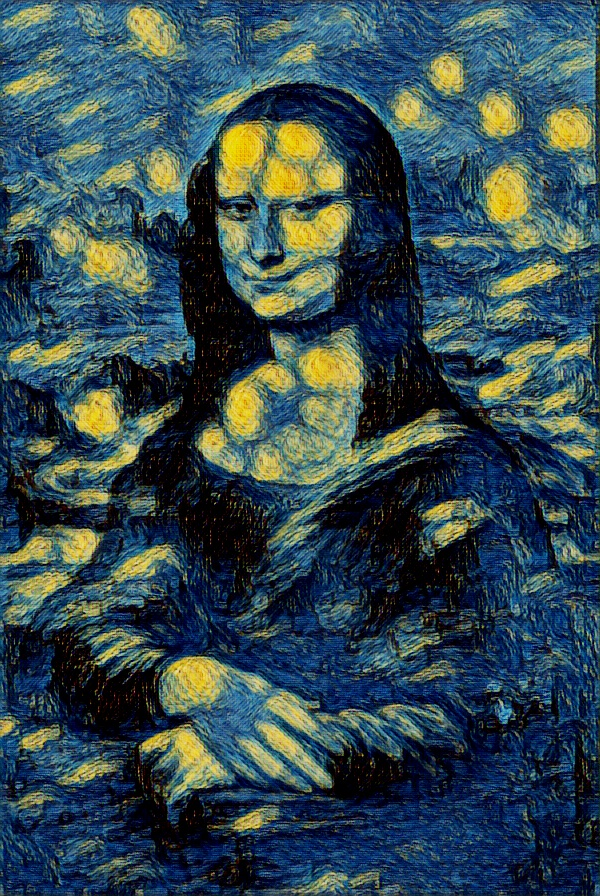